In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

TO UPDATE WITH BATCH SGD

Sigmoid neurons

In [2]:
d = 100 # dimension of space
M = 20 # number of neurons for generation

In [3]:
def sigma(x):
    return (1. / (1. + np.exp(-x)))

In [4]:
class Neuron:
    def __init__(self):
        self.a = np.random.normal(loc = 2., scale = 10.)
        self.w = np.random.normal(size = d)
        self.b = np.random.normal()
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * sigma(self.w.dot(x) + self.b)

In [9]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def zero_out(self):
        for nr in self.neurons:
            nr.set_weights(0., nr.w, nr.b)
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([sigma(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*s[i]*(1-s[i]) for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            for i in range(X.shape[0]):
                self.step(X[pm[i]], Y[pm[i]], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            X = X / np.linalg.norm(X)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                X[i] = X[i] / np.linalg.norm(X[i])
                Y[i] = self.output(X[i])
            return X, Y

In [10]:
gen_net = Network(M)

Initialize new network with first parameter 0 and others normal.

In [7]:
net = Network(50)
net.zero_out()
X, Y = gen_net.gen_sample(500)

Train it using SGD

In [341]:
net.sgd_train(X, Y, tau = 10., epochs = 150)

epoch 0 : 0.150503393668442
epoch 1 : 0.045700398667837934
epoch 2 : 0.013346272453629574
epoch 3 : 0.010623695415586975
epoch 4 : 0.007245788248278647
epoch 5 : 0.004706663071005222
epoch 6 : 0.004584684399085671
epoch 7 : 0.004352908947334137
epoch 8 : 0.005041582098951293
epoch 9 : 0.0035969731529992472
epoch 10 : 0.0032400120049826927
epoch 11 : 0.0031670744658083053
epoch 12 : 0.004007240660093186
epoch 13 : 0.002575921123175446
epoch 14 : 0.002465981579080774
epoch 15 : 0.0025478614415571986
epoch 16 : 0.0023592445128732473
epoch 17 : 0.0027108530663846483
epoch 18 : 0.002199016561237804
epoch 19 : 0.0018679692502385585


KeyboardInterrupt: 

Make several experiments for different values of $m$

In [8]:
np.logspace(0.7, 1.8, 10, base = 10.)

array([ 5.01187234,  6.64082785,  8.79922544, 11.65914401, 15.44859148,
       20.46968272, 27.12272579, 35.93813664, 47.61872663, 63.09573445])

In [17]:
m_range = np.logspace(0.6, 2.0, 15, base = 10.)
m_range = [int(b) for b in m_range]
rep = 1
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    Xt, Yt = gen_net.gen_sample(1000)
    for mi in range(len(m_range)):
        m = m_range[mi]
        net = Network(m)
        net.zero_out()
        X, Y = gen_net.gen_sample(200000)
        train_loss = net.sgd_train(X, Y, tau = 10., epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)



  0%|          | 0/1 [00:00<?, ?it/s]

train 0.04555272258339095
test 0.04312603293979568
3
train 0.002788041309542656
test 0.0028067735395059124
5
train 0.0036540518759705758
test 0.0035677608210478943
6
train 0.0023535163412862323
test 0.0022608633330757047
7
train 0.0015124930043622887
test 0.0014850566252882066
10
train 0.0011066522802304006
test 0.0010812141681986614
12
train 0.001372911717349591
test 0.0013062463232219016
15
train 0.0006929997465037714
test 0.0006314509526075711
19
train 0.0005188183700364401
test 0.00048339084852512613
25
train 0.0007938843253806012
test 0.0006822582375774029
31
train 0.0005257802872972529
test 0.0005154494326666711
39
train 0.0004891326193913201
test 0.0004656540683039017
50
train 0.0006046744819232969
test 0.0005613271295687062
63


KeyboardInterrupt: 

/Users/eloise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


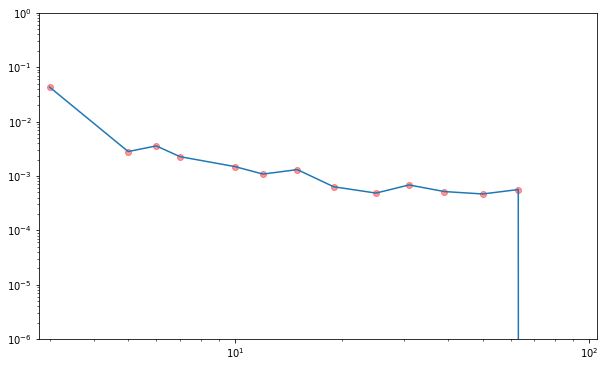

In [18]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='r', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)))
plt.yscale('log')
plt.xscale('log')
plt.xlim((2.8, 105))
plt.ylim((1e-6, 1))
plt.show()

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time